# 2-ColumnarDatastructure
For some applications, it's easier to access structural information in a simple columnar data structure. The ColumnarStructure class represents most data as atom-based numpy arrays. For high performance, it's best to use numpy operations whenever possible. This tutorial shows how to use boolean indexing to extract C-alpha coordinates from the datastructure.

In [19]:
from pyspark.sql import SparkSession
from mmtfPyspark.io import mmtfReader
from mmtfPyspark.utils import traverseStructureHierarchy, ColumnarStructure
from mmtfPyspark import structureViewer
import numpy as np
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt

%matplotlib inline

#### Configure Spark

In [2]:
spark = SparkSession.builder.master("local[4]").appName("2-ColumnarStructure").getOrCreate()
sc = spark.sparkContext

### Download an example structure
Here we download an HIV protease structure with a bound ligand (Nelfinavir).

In [3]:
pdb = mmtfReader.download_full_mmtf_files(["1OHR"], sc)

Structures are represented as keyword-value pairs (tuples):
* key: structure identifier (e.g., PDB ID)
* value: MmtfStructure (structure data)

In this case, we only have one structure, so we can use the first() method to extract the data.

In [4]:
structure = pdb.values().first()

## Create a columnar structure from an MMTF structure
Here we convert an MMTF structure to a columnar structure. By specifying the firstModel flag, we
only retrieve data for the first model (this structure has only one model, anyways).

In [5]:
arrays = ColumnarStructure(structure, firstModelOnly=True)

### Get atom coordinates as numpy arrays

In [6]:
x = arrays.get_x_coords()
y = arrays.get_y_coords()
z = arrays.get_z_coords()
type(z)

numpy.ndarray

### Get entity types
Entity types can be used to distinguish polymer from non-polymer groups and select specific components, e.g., all protein groups. The following entity types are available:
* **Polymer groups**
 * PRO: protein
 * DNA: DNA
 * RNA: RNA
 * PSR: saccharide
* **Non-polymer groups**
 * LGO: ligand organic
 * LGI: ligand inorganic
 * SAC: saccaride
 * WAT: water

In [7]:
entity_types = arrays.get_entity_types()
entity_types

array(['PRO', 'PRO', 'PRO', ..., 'WAT', 'WAT', 'WAT'], dtype=object)

### Get atom, group, and chain name arrays

In [8]:
atom_names = arrays.get_atom_names()
atom_names

array(['N', 'CA', 'C', ..., 'O', 'H1', 'H2'], dtype=object)

In [9]:
group_names = arrays.get_group_names()
group_names

array(['PRO', 'PRO', 'PRO', ..., 'HOH', 'HOH', 'HOH'], dtype=object)

In [10]:
chain_names = arrays.get_chain_names()
chain_names

array(['A', 'A', 'A', ..., 'B', 'B', 'B'], dtype=object)

## Boolean array indexing
Boolean indexing is an efficient way to access selected elements from numpy arrays. 

Here, we calculate an index for C-alpha atoms in proteins in chain A.

In [11]:
ca_idx = (atom_names == 'CA') & (entity_types == 'PRO') & (chain_names == 'A')
ca_idx

array([False,  True, False, ..., False, False, False])

Then, we apply this index to get the coordinates for the C-alpha atoms

In [12]:
xc = x[ca_idx]
yc = y[ca_idx]
zc = z[ca_idx]

#### Combine separate x, y, and z arrays and swap axes

```
[x0, x1, ..., xn],
[y0, y1, ...,yn],
[z0, z1, ...,zn]
```


to 

```
[x0, y0, z0],
[x1, y1, z1], 
 ...,
[xn, yn, zn]
 ```

In [13]:
coords = np.swapaxes(np.array([xc,yc,zc]), 0, 1)

### Calculate distance matrix & map

In [20]:
dist_matrix = squareform(pdist(coords), 'euclidean')

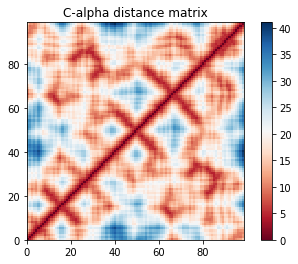

In [21]:
plt.pcolor(dist_matrix, cmap='RdBu')
plt.title('C-alpha distance matrix')
plt.gca().set_aspect('equal')
plt.colorbar();

#### Calculate distance map
Only consider C-alpha - C-alpha distance <= 9. We use boolean indexing to set all distance > 9 to zero.

In [22]:
dist_matrix[dist_matrix > 9] = 0

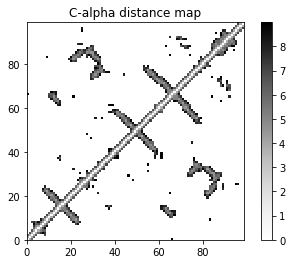

In [23]:
plt.pcolor(dist_matrix, cmap='Greys')
plt.title('C-alpha distance map')
plt.gca().set_aspect('equal')
plt.colorbar();

In [24]:
spark.stop()